In [1]:
import numpy as np
from skimage.io import imread, imsave
from pyclesperanto_prototype import imshow
import pyclesperanto_prototype as cle
import pandas as pd
import matplotlib.pyplot as plt
import nd2

In [2]:
bead_image = nd2.imread("100x_PSF_postmag.nd2")[:,2,:,:]
bead_image.shape

(101, 2304, 2304)

In [7]:
nd2.ND2File("100x_PSF_postmag.nd2").metadata.channels[0]

/tmp/ipykernel_35309/2055507892.py:1: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  nd2.ND2File("100x_PSF_postmag.nd2").metadata.channels[0]


Channel(channel=ChannelMeta(name='TetraOrange1', index=0, colorRGB=49151, emissionLambdaNm=595.0, excitationLambdaNm=561.0), loops=LoopIndices(NETimeLoop=None, TimeLoop=None, XYPosLoop=None, ZStackLoop=0), microscope=Microscope(objectiveMagnification=100.0, objectiveName='Plan Apo λ 100x Oil Ph3 DM', objectiveNumericalAperture=1.45, zoomMagnification=1.5, immersionRefractiveIndex=1.515, projectiveMagnification=None, pinholeDiameterUm=None, modalityFlags=['fluorescence']), volume=Volume(axesCalibrated=(True, True, True), axesCalibration=(0.043333333333333335, 0.043333333333333335, 0.05), axesInterpretation=('distance', 'distance', 'distance'), bitsPerComponentInMemory=16, bitsPerComponentSignificant=16, cameraTransformationMatrix=(-1.0, -6.982962677686267e-15, 6.982962677686267e-15, -1.0), componentCount=1, componentDataType='unsigned', voxelCount=(2304, 2304, 101), componentMaxima=[0.0], componentMinima=[0.0], pixelToStageTransformationMatrix=None))

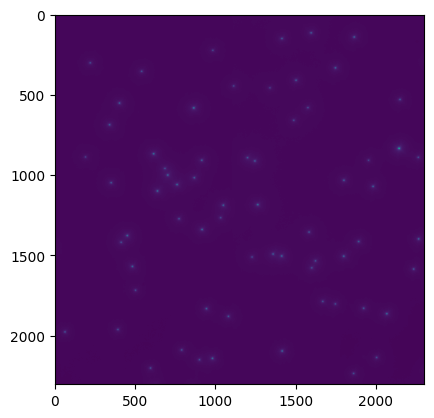

In [4]:
plt.imshow(bead_image.sum(axis=0))

size: 101


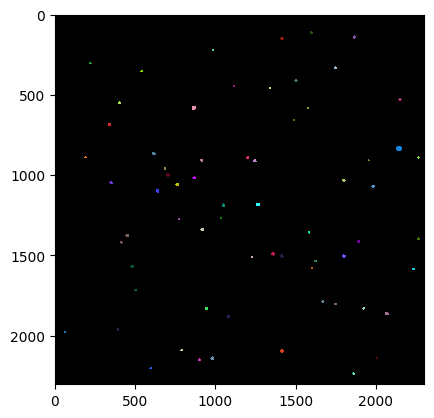

In [5]:
# Segment objects
label_image = cle.voronoi_otsu_labeling(bead_image)
imshow(label_image, labels=True)

In [6]:
# determine center of mass for each object
stats = cle.statistics_of_labelled_pixels(bead_image, label_image)

df = pd.DataFrame(stats)
df[["mass_center_x", "mass_center_y", "mass_center_z"]]

,mass_center_x,mass_center_y,mass_center_z
0,61.884342,1979.288818,42.534424
1,189.621902,889.783447,41.914761
2,219.138916,303.628143,42.977543
3,339.445740,688.884216,43.840935
4,349.269989,1049.927368,42.925400
...,...,...,...
61,2142.429688,836.332153,45.553581
62,2147.904053,531.921021,43.224735
63,2233.177979,1587.875000,42.879631
64,2262.034912,892.074158,41.983833


In [7]:
# Image dimensions
image_width, image_height = 2304, 2304

# PSF radius
psf_radius = 120

# Compute pairwise distances
n = len(df)
distances = np.zeros((n, n))

for i in range(n):
    for j in range(i + 1, n):
        xi, yi = df.iloc[i][['mass_center_x', 'mass_center_y']]
        xj, yj = df.iloc[j][['mass_center_x', 'mass_center_y']]
        dist = np.sqrt((xi - xj) ** 2 + (yi - yj) ** 2)
        distances[i, j] = dist
        distances[j, i] = dist

# Replace diagonal with np.nan
np.fill_diagonal(distances, np.nan)

# Compute average distances
avg_distances = np.nanmean(distances, axis=1)

# Identify isolated objects
to_keep = []

for i in range(n):
    xi, yi = df.iloc[i][['mass_center_x', 'mass_center_y']]
    within_bounds = xi >= psf_radius and xi <= image_width - psf_radius and yi >= psf_radius and yi <= image_height - psf_radius
    if within_bounds and all(distances[i][~np.isnan(distances[i])] >= 200):
        to_keep.append(i)

# Filter the dataframe
filtered_df = df.iloc[to_keep]
filtered_df

,label,original_label,bbox_min_x,bbox_min_y,bbox_min_z,bbox_max_x,bbox_max_y,bbox_max_z,bbox_width,bbox_height,...,centroid_z,sum_distance_to_centroid,mean_distance_to_centroid,sum_distance_to_mass_center,mean_distance_to_mass_center,standard_deviation_intensity,max_distance_to_centroid,max_distance_to_mass_center,mean_max_distance_to_centroid_ratio,mean_max_distance_to_mass_center_ratio
1,2,2,182.0,884.0,27.0,196.0,896.0,56.0,15.0,13.0,...,42.431084,18204.363281,7.445548,18269.839844,7.472327,1952.454712,15.638175,15.123466,2.100339,2.023930
2,3,3,211.0,296.0,25.0,228.0,311.0,59.0,18.0,16.0,...,43.611614,30476.179688,8.430478,30618.392578,8.469817,2200.256104,18.643560,18.009109,2.211447,2.126269
4,5,5,339.0,1041.0,23.0,359.0,1058.0,61.0,21.0,18.0,...,43.713871,45592.429688,9.398562,45845.394531,9.450709,2513.078125,20.815176,20.031706,2.214719,2.119598
5,6,6,383.0,1956.0,24.0,399.0,1973.0,59.0,17.0,18.0,...,42.961288,33540.714844,8.773402,33720.304688,8.820378,2257.552979,19.250744,18.547100,2.194216,2.102756
11,12,12,531.0,348.0,24.0,548.0,364.0,60.0,18.0,17.0,...,43.549782,33862.128906,8.711637,34053.097656,8.760766,2378.076172,19.564209,18.822762,2.245756,2.148529
20,21,21,850.0,571.0,21.0,876.0,595.0,66.0,27.0,25.0,...,45.822163,99322.070312,11.358883,100158.265625,11.454514,3049.706787,24.938982,23.775869,2.195549,2.075677
27,28,28,975.0,219.0,26.0,990.0,232.0,59.0,16.0,14.0,...,43.428913,23339.884766,7.901113,23435.896484,7.933615,1999.687134,17.446209,16.860680,2.208070,2.125220
31,32,32,1106.0,441.0,26.0,1120.0,454.0,59.0,15.0,14.0,...,42.686680,22142.449219,7.821423,22213.019531,7.846351,2121.771973,16.820187,16.841448,2.150528,2.146405
35,36,36,1249.0,1174.0,22.0,1274.0,1197.0,66.0,26.0,24.0,...,45.683453,83923.601562,10.892097,84620.312500,10.982519,2789.104492,24.043968,22.935730,2.207469,2.088385
40,41,41,1403.0,2086.0,21.0,1425.0,2108.0,64.0,23.0,23.0,...,44.767605,71507.609375,10.578049,72074.007812,10.661836,2714.877197,24.110437,23.072552,2.279290,2.164032


Bead 1 at position 189.6219024658203 889.783447265625 41.91476058959961


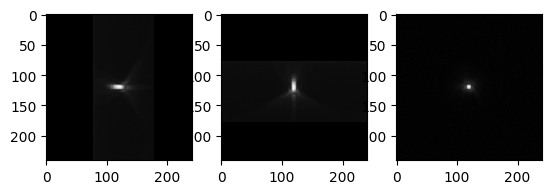

Bead 2 at position 219.138916015625 303.6281433105469 42.977542877197266


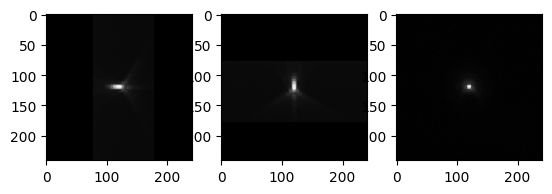

Bead 4 at position 349.2699890136719 1049.9273681640625 42.92539978027344


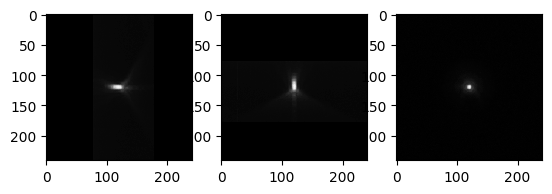

Bead 5 at position 391.430908203125 1964.2266845703125 42.25539779663086


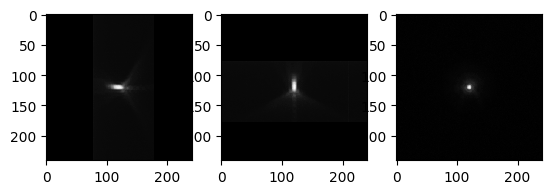

Bead 11 at position 539.3136596679688 356.25262451171875 42.80854797363281


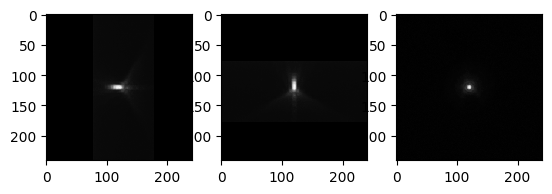

Bead 20 at position 863.6854248046875 584.0380249023438 44.65185546875


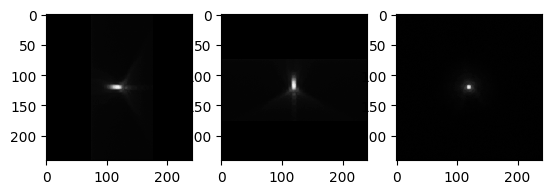

Bead 27 at position 982.3455810546875 225.6653289794922 42.84400177001953


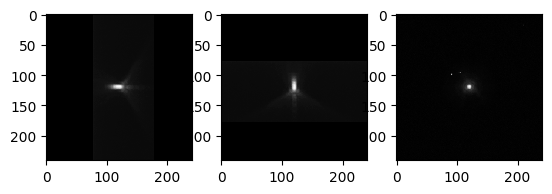

Bead 31 at position 1112.4273681640625 447.5132141113281 42.175331115722656


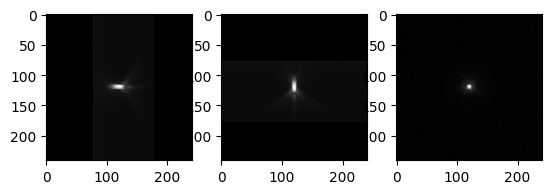

Bead 35 at position 1262.31982421875 1186.4737548828125 44.55214309692383


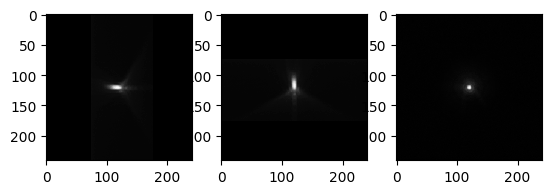

Bead 40 at position 1414.0308837890625 2097.948974609375 43.708709716796875


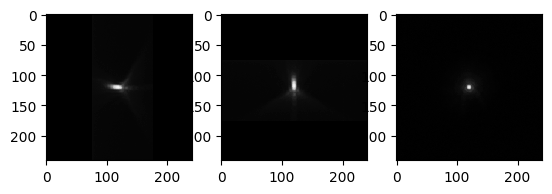

Bead 49 at position 1745.947265625 334.6448059082031 44.228153228759766


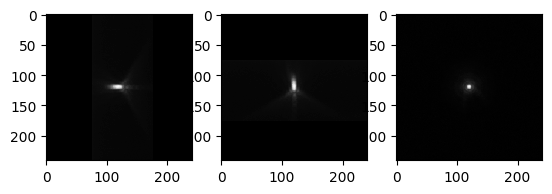

Bead 54 at position 1863.0240478515625 142.67453002929688 44.19320297241211


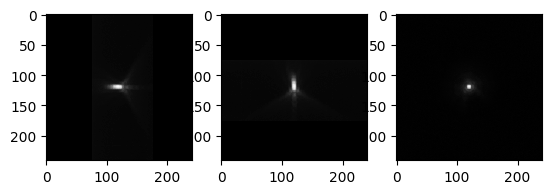

Bead 62 at position 2147.904052734375 531.9210205078125 43.224735260009766


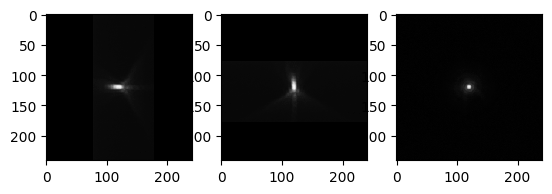

In [8]:
# configure size of future PSF image
size = psf_radius * 2 + 1

# initialize PSF
single_psf_image = cle.create([size, size, size])
avg_psf_image = cle.create([size, size, size])

num_psfs = len(filtered_df)
PSFs = []
for index, row in filtered_df.iterrows():
    x = row["mass_center_x"]
    y = row["mass_center_y"]
    z = row["mass_center_z"]
    
    print("Bead", index, "at position", x, y, z)
    
    # move PSF in right position in a smaller image
    cle.translate(bead_image, single_psf_image, 
                  translate_x= -x + psf_radius,
                  translate_y= -y + psf_radius,
                  translate_z= -z + psf_radius)

    # visualize
    fig, axs = plt.subplots(1,3)    
    imshow(cle.maximum_x_projection(single_psf_image), plot=axs[0])
    imshow(cle.maximum_y_projection(single_psf_image), plot=axs[1])
    imshow(cle.maximum_z_projection(single_psf_image), plot=axs[2])
    plt.show()
    # average
    avg_psf_image = avg_psf_image + single_psf_image / num_psfs
    PSFs.append(np.sum(single_psf_image, axis=0))

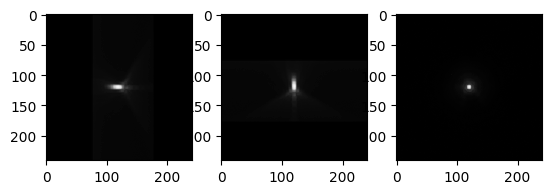

In [9]:
fig, axs = plt.subplots(1,3)    
imshow(cle.maximum_x_projection(avg_psf_image), plot=axs[0])
imshow(cle.maximum_y_projection(avg_psf_image), plot=axs[1])
imshow(cle.maximum_z_projection(avg_psf_image), plot=axs[2])

In [10]:
avg_psf_image.shape

(241, 241, 241)

In [11]:
imsave("average_100x_PSF_postmag_515nm.tif", avg_psf_image )